soydata ([https://github.com/lovit/synthetic_dataset](https://github.com/lovit/synthetic_dataset)) 에서 데이터를 만드는 패키지를 git clone 을 통하여 다운로드 받습니다. `python setup.py install` 명령을 통하여 패키지를 설치합니다.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import soydata
from soydata.data.regression import make_linear_regression_data

print(f'seaborn=={sns.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'soydata=={soydata.__version__}')

seaborn==0.9.0
scikit-learn==0.22.2.post1
soydata==0.1.0


선형회귀모델 학습을 위한 데이터를 생성합니다. a, b 는 식 `y=ax+b` 의 계수입니다. `y_true` 는 `y=ax+b` 에 해당하는 y 값이며, `y` 는 여기에 random noise 가 추가된 값입니다. 

In [2]:
X_raw, y, y_true = make_linear_regression_data(n_samples=100,
    a=1.0, b=-0.5, noise=1, x_range=(-1, 1), seed=0)

print(X_raw.shape)
print(y.shape)
print(y_true.shape)

(100,)
(100,)
(100,)


scatter plot 을 그려 변수 간의 관계를 확인합니다.

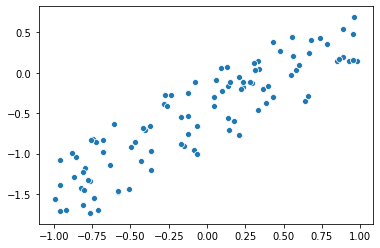

In [3]:
fig = sns.scatterplot(x=X_raw, y=y)

<class 'matplotlib.axes._subplots.AxesSubplot'>


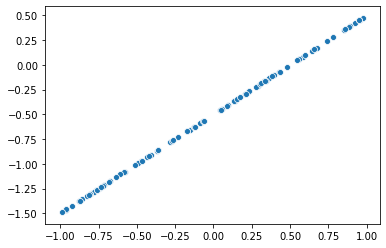

In [4]:
fig2 = sns.scatterplot(x=X_raw, y=y_true)
print(type(fig2))

[0, 1, 2] + [3, 4] -> [0, 1, 2, 3, 4]  처럼 array 를 병합하기 위하여 numpy.concatenate 를 이용할 수 있습니다. 또한 동일한 길이의 list of str 도 만듭니다.

In [5]:
n_data = X_raw.shape[0]
dataset_x = np.concatenate([X_raw, X_raw])
dataset_y = np.concatenate([y, y_true])
dataset_category = ['sample'] * n_data + ['true'] * n_data

print(dataset_x.shape, dataset_y.shape)

(200,) (200,)


이를 Python dict 형식의 `dataset` 이란 변수로 만든 뒤, 이를 pandas DataFrame 으로 변환합니다.

In [6]:
dataset = {
    'x': dataset_x,
    'y': dataset_y,
    'category': dataset_category
}

source = pd.DataFrame(dataset)
source.head()

,x,y,category
0,0.097627,-0.224556,sample
1,0.430379,-0.299613,sample
2,0.205527,-0.059279,sample
3,0.089766,0.051955,sample
4,-0.152690,-0.903937,sample


Seaborn 의 `seaborn.scatterplot()` 과 `seaborn.relplot(..., kind='scatter')` 의 차이를 구분합니다.

<class 'seaborn.axisgrid.FacetGrid'>


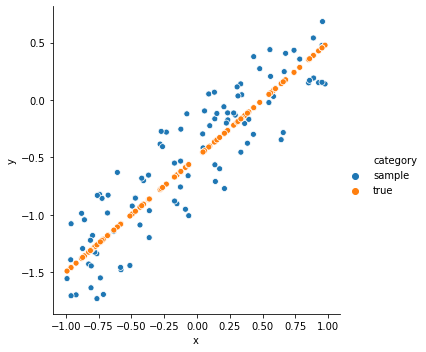

In [7]:
fig3 = sns.relplot(x='x', y='y', hue='category', kind='scatter', data=source)
print(type(fig3))
# fig3.savefig('tmp.png')

LinearRegression 모델의 설명은 아래의 문서를 참고하세요.

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

shape = (100,) 인 `X_raw` 를 이용하면 모델이 학습되지 않습니다. error message 를 확인합니다.

In [8]:
from sklearn.linear_model import LinearRegression

# Ordinary least squres Linear Regressuion
linear_regression = LinearRegression(fit_intercept=True)
# linear_regression.fit(X_raw, y)

LinearRegression 에는 2 차원 이상의 벡터들이 학습에 이용될 수 있기 때문에 언제나 input data 를 column vector 가 아닌 행렬 형태로 입력받습니다. Column vector 는 reshape 을 이용하여 shape = (n,1) 형식의 행렬로 변환합니다.

In [9]:
# colume vector -> matrix
X = X_raw.reshape(-1,1)
linear_regression.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

`predict()` 함수는 학습된 모델을 이용하여 예측을 수행하는 함수입니다. LogisticRegression 등의 대부분의 scikit-learn 에 구현된 모델들에는 `fit_predict()` 함수도 제공됩니다.

In [10]:
y_pred = linear_regression.predict(X)

이번에는 앞서 만든 dataset_x, dataset_y 에 예측에 이용한 값도 덧붙여 `dataset` 을 만듭니다.

In [11]:
dataset = {
    'x': np.concatenate([dataset_x, X_raw]),
    'y': np.concatenate([dataset_y, y_pred]),
    'category': dataset_category + ['prediction'] * n_data
}

source = pd.DataFrame(dataset)
source.tail()

,x,y,category
295,-0.633617,-1.087161,prediction
296,0.173026,-0.306108,prediction
297,-0.959785,-1.402981,prediction
298,0.657880,0.163365,prediction
299,-0.990609,-1.432827,prediction


Column `category` 에는 세 종류의 값이 포함되어 있음을 확인할 수 있습니다.

In [12]:
source['category'].unique()

array(['sample', 'true', 'prediction'], dtype=object)

이를 이용하여 예측값까지 그림으로 그려봅니다.

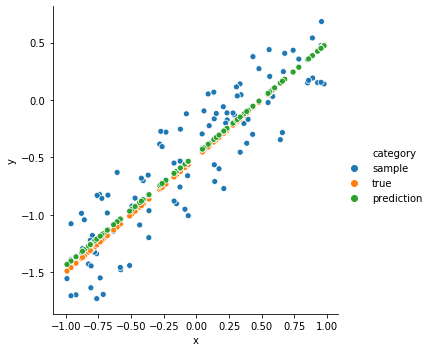

In [13]:
fig4 = sns.relplot(x='x', y='y', hue='category', kind='scatter', data=source)

모델의 패러매터 a, b 는 각각 `intercept_` 와 `coef_` 에 저장되어 있습니다.

In [14]:
a_est = linear_regression.coef_
b_est = linear_regression.intercept_

print(f'a_est = {a_est}, type = {type(a_est)}, shape = {a_est.shape}')
print(f'b_est = {b_est:.3}, type = {type(b_est)}, shape = {b_est.shape}')

a_est = [0.96827553], type = <class 'numpy.ndarray'>, shape = (1,)
b_est = -0.474, type = <class 'numpy.float64'>, shape = ()


학습 성능을 확인하기 위하여 residual 을 정의합니다.

In [15]:
residual = y - y_pred
residual[:5]

array([ 0.15455815, -0.24269404,  0.2153587 ,  0.43868078, -0.28244643])

In [16]:
# print(np.array([1, 2, 3]) / np.array([3, 4, 5]))
# [0.33333333 0.5        0.6       ]

# print(np.array([1, 2, 3]) ** 2)
# [1 4 9]

# print(np.array([1, 2, 3]) - 0.5)
# [0.5 1.5 2.5]

MAE, MAPE, MSE, RMSE, R-square 를 직접 계산해 봅니다.

In [17]:
performance = {
    'mae' : np.abs(residual).mean(),
    'mape': (np.abs(residual) / np.abs(y)).mean(),
    'mse' : (residual ** 2).mean(),
    'rmse': np.sqrt( (residual ** 2).mean() ),
    'r2'  : 1 - (residual ** 2).sum() / ((y - y.mean()) **2).sum()
}

performance

{'mae': 0.23709498511190305,
 'mape': 0.9255390530290607,
 'mse': 0.07623324582875006,
 'rmse': 0.2761036867351649,
 'r2': 0.8034942875609504}

```
whos
```

위의 명령어는 IPython 에서 현재의 Python kernel 이 이용하는 변수의 이름과 타입, 그리고 간단한 변수 정보를 표현해 줍니다. 함수는 `<function ....> at ...` 과 같은 형태로 표현됩니다. 변수는 그 크기 혹은 값의 일부가 출력됩니다. Notebook 도 IPython 기반으로 동작하기 때문에 `whos` 명령어를 이용할 수 있습니다.

In [18]:
whos

Variable                      Type                Data/Info
-----------------------------------------------------------
LinearRegression              ABCMeta             <class 'sklearn.linear_mo<...>._base.LinearRegression'>
X                             ndarray             100x1: 100 elems, type `float64`, 800 bytes
X_raw                         ndarray             100: 100 elems, type `float64`, 800 bytes
a_est                         ndarray             1: 1 elems, type `float64`, 8 bytes
b_est                         float64             -0.47364444574109427
dataset                       dict                n=3
dataset_category              list                n=200
dataset_x                     ndarray             200: 200 elems, type `float64`, 1600 bytes
dataset_y                     ndarray             200: 200 elems, type `float64`, 1600 bytes
fig                           AxesSubplot         AxesSubplot(0.125,0.125;0.775x0.755)
fig2                          AxesSubplot       